In [1]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split

# Path to your dataset
dataset_path = '/kaggle/input/fruit-images-for-object-detection/train_zip/train'
image_dir = dataset_path   # Directory containing the images

# List of image filenames
image_filenames = os.listdir(dataset_path)

# Extract labels (fruit type) from filenames (assuming filename format: fruitname_number.jpg)
labels = [filename.split('_')[0] for filename in image_filenames if filename.endswith('.jpg')]

# Display the unique labels
print(f"Unique labels: {set(labels)}")


Unique labels: {'mixed', 'orange', 'banana', 'apple'}


In [12]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder to convert fruit names to integer labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Preprocess images: resize to ResNet input size (224x224)
def preprocess_image(image_path, target_size=(224, 224)):
    # Load and resize the image
    image = load_img(image_path, target_size=target_size)
    image = img_to_array(image)
    image = tf.keras.applications.resnet50.preprocess_input(image)  # Preprocess for ResNet50
    return image

# Process all images
images = []
for filename in image_filenames:
    if filename.endswith('.jpg'):
        image_path = os.path.join(image_dir, filename)
        image = preprocess_image(image_path)
        images.append(image)

# Convert to numpy arrays
images = np.array(images)
encoded_labels = np.array(encoded_labels)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, encoded_labels, test_size=0.2, random_state=42)

# One-hot encode labels
y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=len(label_encoder.classes_))
y_test_one_hot = tf.keras.utils.to_categorical(y_test, num_classes=len(label_encoder.classes_))


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [ ]:
from tensorflow.keras.applications import ResNet50,ResNet101
from tensorflow.keras import layers, models

# Load the pre-trained ResNet50 model (without the top fully connected layers)
base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
base_model.trainable = False

# Add classification head
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
output = layers.Dense(len(label_encoder.classes_), activation='softmax')(x)  # One output for each class

# Create the final model
model = models.Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Non-trainable params: 42,658,176 (162.73 MB)

In [18]:
# Train the model
history = model.fit(X_train, y_train_one_hot, epochs=30, batch_size=16, validation_data=(X_test, y_test_one_hot))


Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 648ms/step - accuracy: 0.6096 - loss: 1.0762 - val_accuracy: 0.9583 - val_loss: 0.1847
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.9746 - loss: 0.1055 - val_accuracy: 0.9583 - val_loss: 0.1882
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.9988 - loss: 0.0133 - val_accuracy: 0.9375 - val_loss: 0.3712
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 1.0000 - loss: 0.0074 - val_accuracy: 0.9792 - val_loss: 0.2365
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.9792 - val_loss: 0.2049
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 1.0000 - loss: 7.2497e-04 - val_accuracy: 0.9792 - val_loss: 0.2212
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 1.0000 - loss: 5.6223e-04 - val_accuracy: 0.9792 - val_loss: 0.2341
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 1.0000 - loss: 5.0399e-04 - val_

In [19]:
model.evaluate(X_test, y_test_one_hot)


2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.9757 - loss: 0.2708


[0.23365606367588043, 0.9791666865348816]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


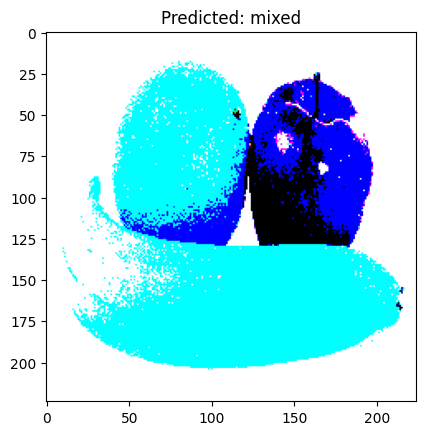

In [20]:
import matplotlib.pyplot as plt

# Function to plot image with predicted label
def plot_image_with_prediction(image, prediction, label_encoder):
    plt.imshow(image)
    predicted_label = label_encoder.inverse_transform([np.argmax(prediction)])[0]
    plt.title(f"Predicted: {predicted_label}")
    plt.show()

# Example visualization for the first test image
prediction = model.predict(np.expand_dims(X_test[0], axis=0))
plot_image_with_prediction(X_test[0], prediction, label_encoder)


2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step


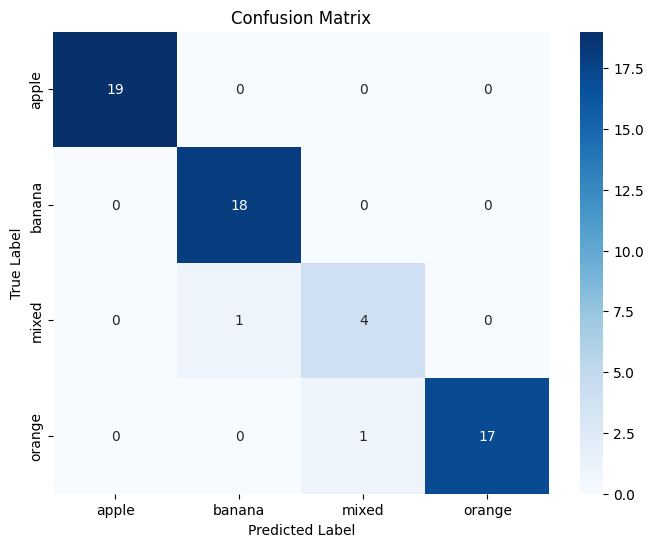

Classification Report:
               precision    recall  f1-score   support

       apple       1.00      1.00      1.00        19
      banana       0.95      1.00      0.97        18
       mixed       0.80      0.80      0.80         5
      orange       1.00      0.94      0.97        18

    accuracy                           0.97        60
   macro avg       0.94      0.94      0.94        60
weighted avg       0.97      0.97      0.97        60



In [24]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your model is already trained and you have test_images and true_labels
# Example:
# test_images: preprocessed test images (e.g., a NumPy array of shape (num_images, 224, 224, 3))
# true_labels: true labels of the test images (as a list or NumPy array)

# Get predictions from the model
predictions = model.predict(test_images)

# Convert predictions to label indices (most probable class)
predicted_labels = np.argmax(predictions, axis=1)

# If you used a label encoder during training:
# Convert true labels to label indices using label encoder
true_labels = np.array([label_encoder.transform([label])[0] for label in true_labels])

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Generate the classification report
report = classification_report(true_labels, predicted_labels, target_names=label_encoder.classes_)
print("Classification Report:\n", report)


In [21]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

# Path to your test images directory
test_image_dir = '/kaggle/input/fruit-images-for-object-detection/test_zip/test'

# List of image filenames
test_image_filenames = os.listdir(test_image_dir)

# Load and preprocess test images
def preprocess_image(image_path, target_size=(224, 224)):
    image = load_img(image_path, target_size=target_size)
    image = img_to_array(image)
    image = tf.keras.applications.resnet50.preprocess_input(image)  # Preprocess for ResNet50
    return image

# Prepare the test images and labels
test_images = []
true_labels = []

for filename in test_image_filenames:
    if filename.endswith('.jpg'):
        # Extract the true label from the filename (assumed to be the fruit name)
        label = filename.split('_')[0]  # Assumes the label is the first part of the filename
        true_labels.append(label)

        # Preprocess the image
        image_path = os.path.join(test_image_dir, filename)
        image = preprocess_image(image_path)
        test_images.append(image)

# Convert lists to numpy arrays
test_images = np.array(test_images)


In [8]:
# Make predictions on the test images
predictions = model.predict(test_images)

# Decode the predictions
predicted_labels = np.argmax(predictions, axis=1)  # Get the index of the highest probability

# Convert predicted labels back to the fruit names using label_encoder
predicted_labels = label_encoder.inverse_transform(predicted_labels)

# Print the predicted labels for checking
print(f"Predicted labels: {predicted_labels}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step
Predicted labels: ['apple' 'mixed' 'orange' 'orange' 'apple' 'orange' 'banana' 'apple'
 'apple' 'mixed' 'apple' 'banana' 'apple' 'apple' 'banana' 'apple'
 'banana' 'orange' 'apple' 'banana' 'mixed' 'banana' 'apple' 'orange'
 'orange' 'apple' 'orange' 'orange' 'orange' 'banana' 'banana' 'orange'
 'orange' 'banana' 'banana' 'orange' 'banana' 'apple' 'apple' 'banana'
 'orange' 'banana' 'orange' 'orange' 'apple' 'apple' 'banana' 'apple'
 'orange' 'banana' 'orange' 'orange' 'apple' 'banana' 'banana' 'apple'
 'banana' 'mixed' 'orange' 'banana']


In [22]:
# Compare predicted labels with the true labels
correct_count = 0
wrong_count = 0

for i in range(len(true_labels)):
    true_label = true_labels[i]
    predicted_label = predicted_labels[i]

    if true_label == predicted_label:
        correct_count += 1
    else:
        wrong_count += 1
        print(f"Wrong: True label = {true_label}, Predicted label = {predicted_label}")

# Output the results
print(f"\nTotal images: {len(true_labels)}")
print(f"Correct predictions: {correct_count}")
print(f"Wrong predictions: {wrong_count}")


Wrong: True label = mixed, Predicted label = banana
Wrong: True label = apple, Predicted label = orange

Total images: 60
Correct predictions: 58
Wrong predictions: 2


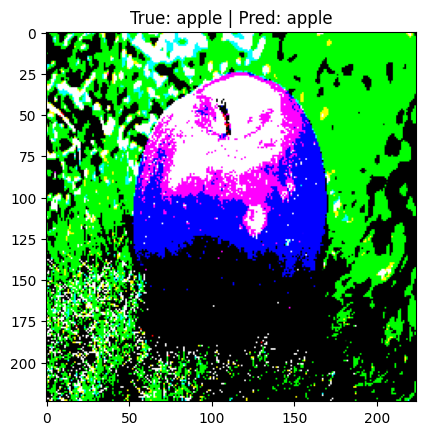

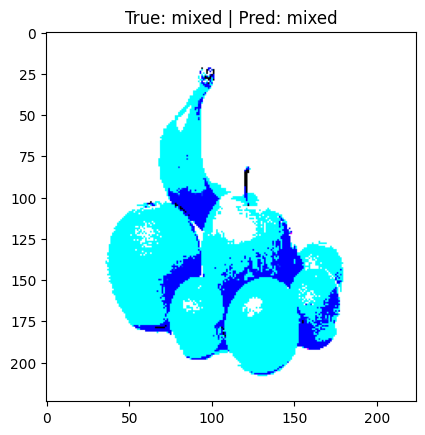

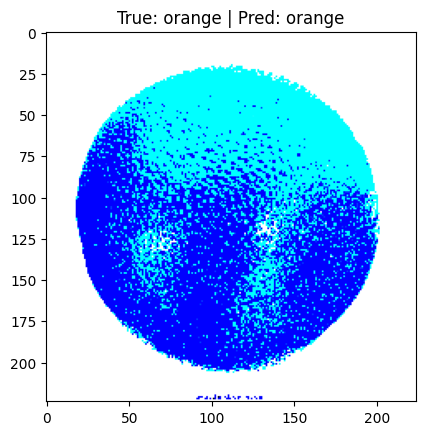

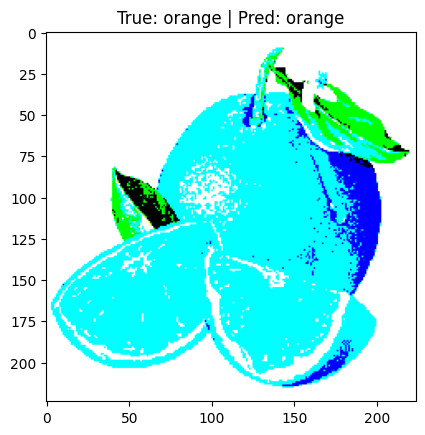

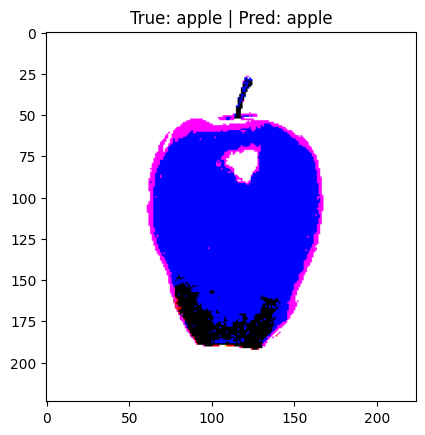

In [23]:
def plot_image_with_prediction(image, true_label, predicted_label):
    plt.imshow(image)
    plt.title(f"True: {true_label} | Pred: {predicted_label}")
    plt.show()

# Display the first few images with their predictions
for i in range(min(5, len(true_labels))):  # Display first 5 images
    plot_image_with_prediction(test_images[i], true_labels[i], predicted_labels[i])
